Since this model was the one of the bests, we trained this model with the whole dataset again.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Define the dataset class
class YelpDataset(Dataset):
    def __init__(self, input_ids, token_type_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'token_type_ids': self.token_type_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }


In [2]:
# Load each part of the dataset
data_parts = []
for i in range(1, 6):
    part_data = torch.load(f'./YELP-Rating/prep2_yelp_data_part_{i}.pt')
    data_parts.append(part_data)

In [3]:
from torch.utils.data import TensorDataset, DataLoader
# Combine data_parts into a single TensorDataset
full_dataset = TensorDataset(
    torch.cat([part['input_ids'] for part in data_parts]),
    torch.cat([part['token_type_ids'] for part in data_parts]),
    torch.cat([part['attention_mask'] for part in data_parts]),
    torch.cat([part['labels'] for part in data_parts])
)

In [4]:
# Load each part of the dataset
data_parts = []
for i in range(1, 6):
    part_data = torch.load(f'./YELP-Rating/test_prep2_yelp_data_part_{i}.pt')
    data_parts.append(part_data)

In [5]:
from torch.utils.data import TensorDataset, DataLoader
# Combine data_parts into a single TensorDataset
test_dataset = TensorDataset(
    torch.cat([part['input_ids'] for part in data_parts]),
    torch.cat([part['token_type_ids'] for part in data_parts]),
    torch.cat([part['attention_mask'] for part in data_parts]),
    torch.cat([part['labels'] for part in data_parts])
)

In [6]:
del data_parts

In [7]:
#subset_indices = range(500)  # Example indices for the subset

#full_dataset = torch.utils.data.Subset(full_dataset, subset_indices)

In [8]:
import torch
from sklearn.model_selection import train_test_split


# Use train_test_split to split the dataset into training, validation, and test sets
train_size = int(0.9 * len(full_dataset))
val_size = (len(full_dataset) - train_size)

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

# Define batch size
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [9]:
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertForSequenceClassification, BertConfig
from transformers import modeling_outputs
import torch.nn as nn
import torch.nn.functional as F

class EnhancedBertClassifier(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_labels=5):
        super(EnhancedBertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.attention = nn.MultiheadAttention(embed_dim=self.bert.config.hidden_size, num_heads=8)
        self.layer_norm = nn.LayerNorm(self.bert.config.hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Dropout(self.bert.config.hidden_dropout_prob),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.LayerNorm(64),
            nn.Dropout(self.bert.config.hidden_dropout_prob),
            nn.Linear(64, num_labels)
        )
        
    def forward(self, input_ids, attention_mask, token_type_ids, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state
        attn_output, _ = self.attention(sequence_output, sequence_output, sequence_output)
        attn_output = self.layer_norm(attn_output + sequence_output)  # Residual connection and layer normalization
        pooled_output = attn_output.mean(dim=1)
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        
        return modeling_outputs.SequenceClassifierOutput(
        loss=loss,
        logits=logits)

model = EnhancedBertClassifier()

# Specify hyperparameters
epochs = 4
bert_learning_rate = 1e-5  # Lower learning rate for BERT parameters
classifier_learning_rate = 5e-4
warmup_steps = 3

bert_layers = model.bert.encoder.layer
num_bert_layers = len(bert_layers)
bert_params_last_6 = []
classifier_params = []

for name, param in model.named_parameters():
    if name.startswith('bert.embeddings') or (name.startswith('bert.encoder.layer') and int(name.split('.')[3]) < 7):
        param.requires_grad = False
    if (name.startswith('bert.encoder.layer') and int(name.split('.')[3]) >= 7):
        bert_params_last_6.append(param)
    if ((name.startswith('classifier')) or (name.startswith('bert.pooler')) or (name.startswith('attention')) or (name.startswith('layer_norm'))):
        classifier_params.append(param)

# Set up the optimizer with different learning rates for BERT layers and classifier
optimizer_grouped_parameters = [
    {'params': bert_params_last_6, 'lr': bert_learning_rate},
    {'params': classifier_params, 'lr': classifier_learning_rate}
]
optimizer = AdamW(optimizer_grouped_parameters)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


EnhancedBertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [ ]:
%%capture outs1
# Training loop
for epoch in range(epochs):
    # Training loop with tqdm
    model.train()
    total_train_loss = 0
    total_train_accuracy = 0
    print(f'Epoch {epoch+1}/{epochs}')
    #progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} (Training)')
    for batch in train_loader:
    #for batch in progress_bar_train:
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        labels = batch[3].to(device)
        
        model.zero_grad()
        
        outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        total_train_loss += loss.item()
        
        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == labels).float().mean()
        total_train_accuracy += accuracy.item()
        
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        #progress_bar_train.set_postfix({'Training Loss': total_train_loss / len(progress_bar_train), 'Training Accuracy': total_train_accuracy / len(progress_bar_train)})

    # Validation loop with tqdm
    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    #print(f'Epoch {epoch+1}/{epochs} (Validation)')
    #progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} (Validation)')
    with torch.no_grad():
        for batch in val_loader:
        #for batch in progress_bar_val:
            input_ids = batch[0].to(device)
            token_type_ids = batch[1].to(device)
            attention_mask = batch[2].to(device)
            labels = batch[3].to(device)

            outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            total_val_loss += loss.item()
            
            # Calculate accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            accuracy = (predictions == labels).float().mean()
            total_val_accuracy += accuracy.item()
            
            #progress_bar_val.set_postfix({'Validation Loss': total_val_loss / len(progress_bar_val), 'Validation Accuracy': total_val_accuracy / len(progress_bar_val)})
            
    # Calculate average loss and accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    avg_train_accuracy = total_train_accuracy / len(train_loader)
    
    print(f'Training Loss: {total_train_loss / len(train_loader)}, Training Accuracy: {total_train_accuracy / len(train_loader)}')
    print(f'Validation Loss: {total_val_loss / len(val_loader)}, Validation Accuracy: {total_val_accuracy / len(val_loader)}')

In [13]:
outs1()

Epoch 1/4
Training Loss: 0.8226125934376731, Training Accuracy: 0.6392712093862816
Validation Loss: 0.7456464996986737, Validation Accuracy: 0.6694605068897638
Epoch 2/4
Training Loss: 0.7314922203512685, Training Accuracy: 0.6798490318345914
Validation Loss: 0.7173082605444305, Validation Accuracy: 0.68677718996063
Epoch 3/4
Training Loss: 0.6958607956530711, Training Accuracy: 0.6945561207745323
Validation Loss: 0.7028372092685831, Validation Accuracy: 0.6922828494094488
Epoch 4/4
Training Loss: 0.6739806418570292, Training Accuracy: 0.7043027294606717
Validation Loss: 0.7018289785157508, Validation Accuracy: 0.6927903543307087


In [ ]:
%%capture outs2
model.eval()
total_test_loss = 0
total_test_accuracy = 0
progress_bar_test = tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} (Testing)')

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in progress_bar_test:
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        labels = batch[3].to(device)

        outputs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        total_test_loss += loss.item()
        
        # Calculate accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == labels).float().mean()
        total_test_accuracy += accuracy.item()
        
        # Store predictions and true labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar_test.set_postfix({'Testing Loss': total_test_loss / len(progress_bar_test),
                                       'Testing Accuracy': total_test_accuracy / len(progress_bar_test)})
    
# Calculate average loss and accuracy
avg_test_loss = total_test_loss / len(test_loader)
avg_test_accuracy = total_test_accuracy / len(test_loader)

# Print the average testing loss and accuracy
print(f'Average Testing Loss: {avg_test_loss:.4f}, Average Testing Accuracy: {avg_test_accuracy:.4f}')

In [14]:
outs2()

Average Testing Loss: 0.7099, Average Testing Accuracy: 0.6890


Epoch 4/4 (Testing): 100%|##########| 1563/1563 [11:50<00:00,  2.20it/s, Testing Loss=0.71, Testing Accuracy=0.689]   


In [ ]:
# Save the model and its parameters
torch.save(model.state_dict(), 'model_14.pth')

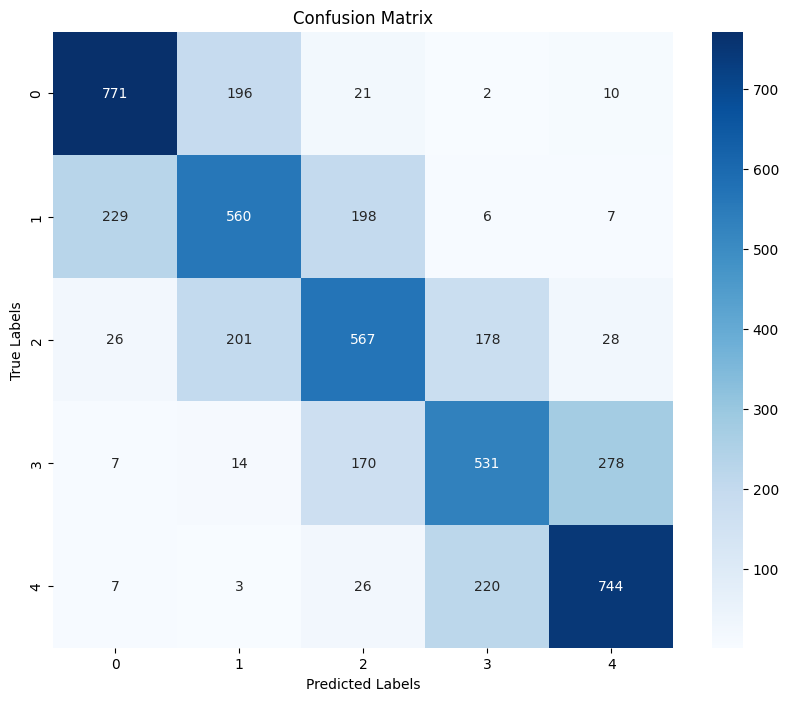

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()